# Filling the Gap Btw Obs. Points

### Step1: Load PKGs
I have copied/pasted most of the packages from the team's script and from the script provided by Jack<br>

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt 
#Used for dealing with our dataframe
import pandas as pd
#Using for finding lat and long coords X nautical miles out
import geopy 
import geopy.distance
from geopy.distance import geodesic
#Used for drawing circles
from numpy import cos,sin,arccos
import numpy as np
#Used for polygon shenanigans
import shapely
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.ops import unary_union
#Used for visualizing
import geopandas as gpd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
# Two packages I have added to interpolate the gaps between observed hurricane
from statsmodels.nonparametric.smoothers_lowess import lowess  # version 0.13.2
from scipy.interpolate import interp1d # version 1.8.1
import warnings

### Step 2: Load Function -- Hurricance Shapefile
I am borrowing the functions from Jack's script

In [3]:
def parametric_circle(t,xc,yc,R):
    x = xc + R*cos(t)
    y = yc + R*sin(t)
    return x,y

def inv_parametric_circle(x,xc,R):
    t = np.arccos(((x-xc)/R))
    return t

def hurricane_shapefile(df, storm_id, wind_speed = 34, quadrant_points = 30):
    '''
    Parameters
    ----------
    df : pandas dataframe
        Hurdat 2 data.
    storm_id : string
        storm ID from hurdat.
    wind_speed : int, possible values are 34, 50, and 64
        DESCRIPTION. The default is 34.
    quadrant_points : INT, # of points in each arc
        DESCRIPTION. The default is 30.

    Returns
    -------
    List of non-empty polygons for the given hurricane
    
    '''
    #Empty list to store our shapes
    storm_shapes = []
    #Bearing for our wind directions
    bearings = [0, 90, 180, 270]
    
    #Subset for our storm
    sub_df = df[df['id'] == storm_id]
    
    for i in range(len(sub_df)):
        #Get the center of our storm
        latitude = sub_df['latitude'].iloc[i]
        longitude = sub_df['longitude'].iloc[i]
        center = geopy.Point(latitude, longitude)
        
        wind_columns = [f'{wind_speed}kt_wind_radii_NE_quad', 
                        f'{wind_speed}kt_wind_radii_SE_quad',
                        f'{wind_speed}kt_wind_radii_SW_qud', 
                        f'{wind_speed}kt_wind_radii_NW_qud']
        
        #Empty list to store the quadrant shapefiles
        quadrant_shapes = []
        for j in range(4):
            wind_miles = sub_df[wind_columns[j]].iloc[i]
            
            if wind_miles == 0:
                continue
            
            #Get the two points that make up the ends of our arc
            p1 = geodesic(nautical = wind_miles).destination(point=geopy.Point(latitude, longitude), bearing= bearings[j])
            p2 = geodesic(nautical = wind_miles).destination(point=geopy.Point(latitude, longitude), bearing= (bearings[j] + 90))
            
            #Treat our radius different depending on the quadrant
            if j == 0:
                radius = (p1.latitude - center.latitude) 
            if j ==1:
                radius = (p2.latitude - center.latitude) * -1
            elif j==2:
                radius = (p1.latitude - center.latitude) 
            elif j==3:
                radius = (p2.latitude - center.latitude) * -1
            
            #Convert our start and end points into tuples
            start_point = tuple([p1.latitude, p1.longitude])
            end_point = tuple([p2.latitude, p2.longitude])
            #Draw our semi-circle
            start_t = inv_parametric_circle(start_point[0], latitude, radius)
            end_t = inv_parametric_circle(end_point[0], latitude, radius)
            arc_T = np.linspace(start_t, end_t, quadrant_points)
            #Get the points from our circle
            X,Y = parametric_circle(arc_T, latitude, longitude, radius)
            points  = list(tuple(zip(Y, X)))
            #Insert the center of the storm as a first point so we can make the polygon
            points.insert(0, (longitude, latitude))
            #Create our polygon
            sub_poly = shapely.geometry.shape({'type': "Polygon", "coordinates": [points]})
            #Append to our list
            quadrant_shapes.append(sub_poly)
            
        #Union together each quadrant to form a circle-ish
        storm_shapes.append(unary_union(quadrant_shapes))
    #Remove any records that had 0 for all wind radii
    storm_shapes = [i for i in storm_shapes if not i.is_empty]
    
    return(storm_shapes)

### Step 3: Load the Hurricane Dataset
As a demonstration, I am going to use the Hurricane Irma, i.e., `hurricane_df[hurricane_df["id"]=='AL112017']`

In [4]:
shapes = gpd.read_file(r'C:\\Users\\songt\\Desktop\\Hurricane_Crop_Acreage-main\\Data/AL112017_radii.shp')
hurricane_df = pd.read_csv(r'https://raw.githubusercontent.com/JackOgozaly/Hurricane_Crop_Acreage/main/Data/historical_hurricane_date.csv')
sub_hurricane_df = hurricane_df[hurricane_df["id"]=='AL112017'].reset_index()
# You can use the index but I like to create a new index column called "ind" to avoid any possible confusion after the subsetting process
sub_hurricane_df["ind"] = range(len(sub_hurricane_df))

### Step 4: Interpolation
We are going to use the lowess function to "smooth" the long/lat <br>
Please see the following page: https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

I have initially tried to model the entire trajectory of the hurricane. It worked pretty well but did not overlap with the observed trajectory, perfectly. So, I will simply fill-in the gaps between the each observations. This process is done by interpolating 100 long/lat pairs for each two consecutive observations. I am basically fitting a local linear regression using two consecutive observations. The only issue is when the latitude changes, but the longitude did not (i.e., the slope of the regression is $\infty$). Please check the if-else statement in the code chunk below.

For the four ordinal directions, interpolation using the local linear regression also made sense since (1) the graph looked smooth, and (2) it scaptures diminishing hurricane at the end until it disappears. However, it involves extrapolation. Hence, decided to use the ordinal directions of the "next" observations for the interpolation.

In [ ]:
df_new = pd.DataFrame()

for i in range(len(sub_hurricane_df)-1):
    x=sub_hurricane_df.longitude[i:i+2]
    y=sub_hurricane_df.latitude[i:i+2]
    if(x[i] != x[i+1]):
        y_hat = lowess(y, x, frac=1/6)
        xnew = np.linspace(x[i], x[i+1], 100)
        f_linear = interp1d(y_hat[:,0], y=y_hat[:,1], bounds_error=False, kind='linear', fill_value='extrapolate') 
        ynew_linear = f_linear(xnew)
    else:
        xnew = np.linspace(x[i], x[i+1], 100)
        ynew_linear = np.linspace(y[i], y[i+1], 100)
    df_new = pd.concat([df_new, pd.DataFrame({
        'ind': sub_hurricane_df.ind[i],
        'longitude':xnew,
        'latitude' : ynew_linear})],axis=0)

# Check for any nan values
# df_new.apply(lambda x: sum(np.isnan(x)))
# df_new[df_new.latitude.isnull()]

# Subset the ordinal directions
ord = sub_hurricane_df[["ind", "64kt_wind_radii_NE_quad", "64kt_wind_radii_SE_quad", "64kt_wind_radii_SW_qud", "64kt_wind_radii_NW_qud"]]
# Add 1 to the "ind" so that we use the "next" ordinal directions for interpolation
ord["ind"] -= 1
df_new = df_new.merge(ord, on="ind", how="left")

# Add the last observation to complete the dataset.
df_new = pd.concat([df_new, sub_hurricane_df[-1:]], axis=0)[df_new.columns].reset_index() # reset index just in case

### Step 5: Plot the Interpolated Hurricane Shapefile and Compare with the Original Observations

Comparion of the entire hurricane trajectory. The code chunk mainly borrowed from the team's script.

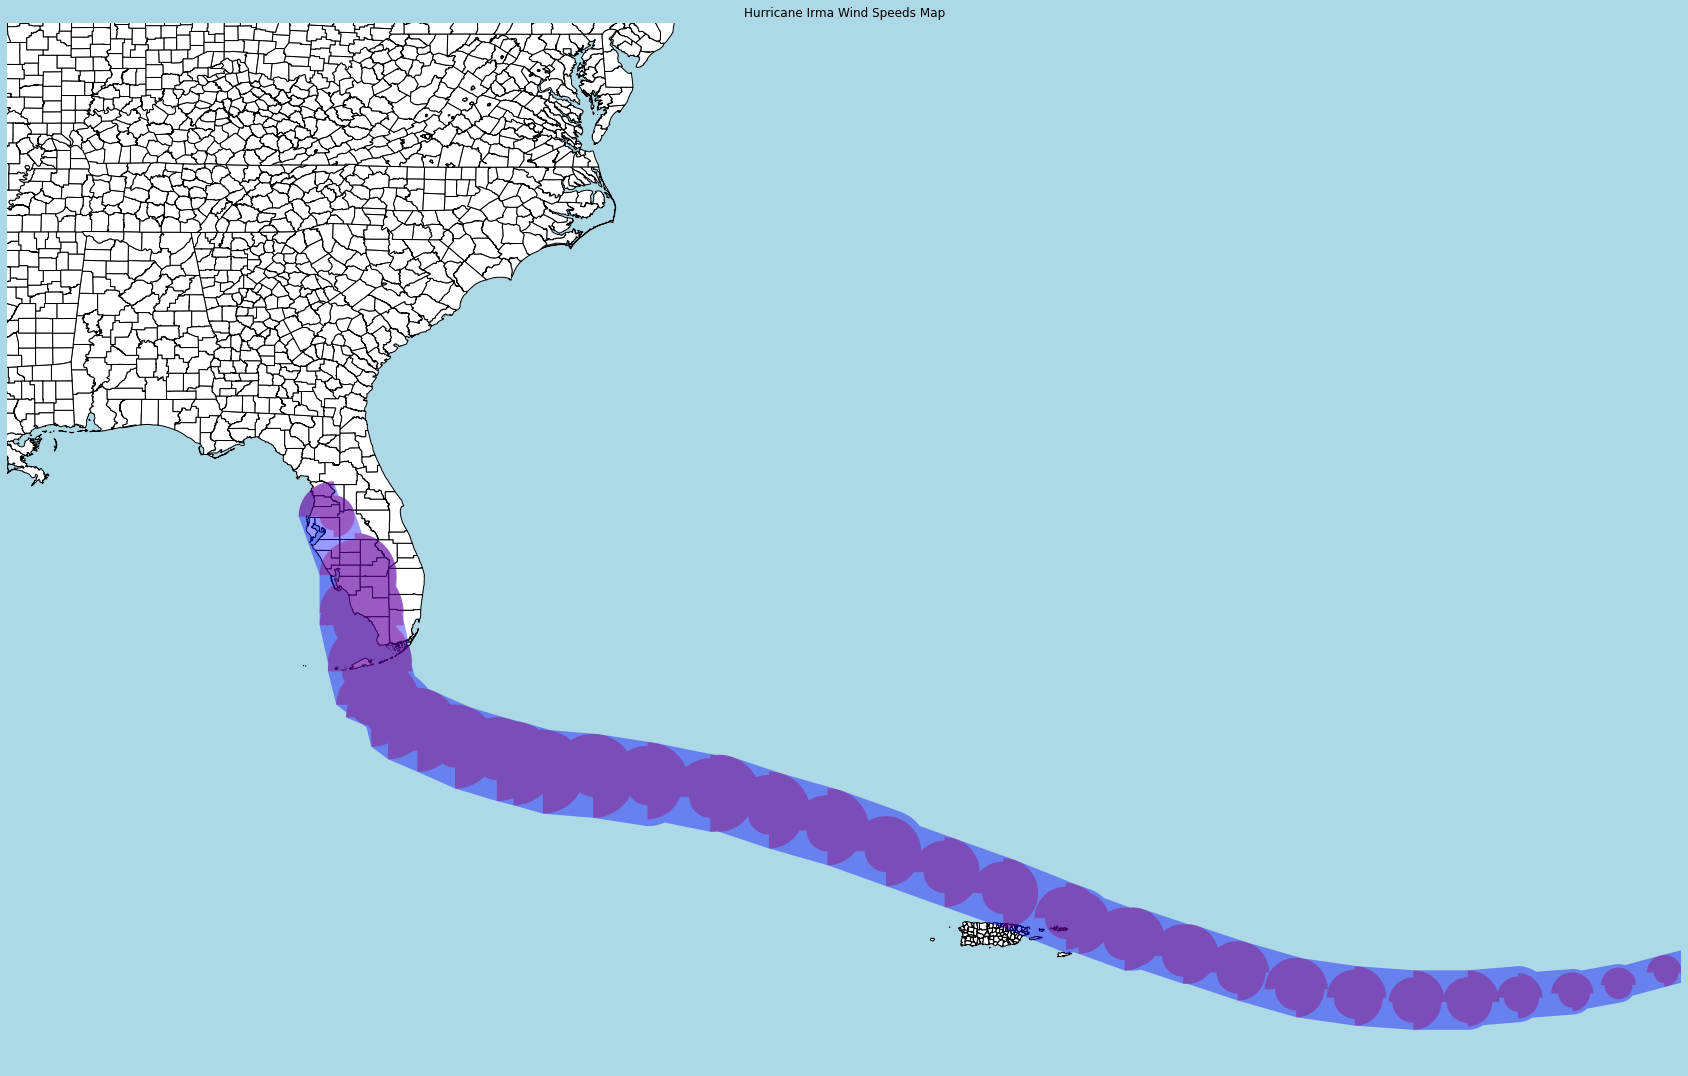

In [10]:
# Compare the observed vs. Interpolated long/lat

df_new["id"] = 'AL112017'
hurricane_irma_n =hurricane_shapefile(df_new, 'AL112017', wind_speed=64)

county_shapes = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip')
fig, ax = plt.subplots(figsize=(30,24))

#Create our county shapefiles and plot them
counties = gpd.GeoSeries(county_shapes['geometry'])
counties.plot(ax=ax, color='white', edgecolor='black')

hurricane_irma_h = hurricane_shapefile(hurricane_df, 'AL112017', wind_speed=64)
irma_shape_h = unary_union(hurricane_irma_h)
p = gpd.GeoSeries(irma_shape_h)
p.plot(ax=ax, color = "red", alpha = .4)

irma_shape_n = unary_union(hurricane_irma_n)
p2 = gpd.GeoSeries(irma_shape_n)
p2.plot(ax=ax, color = "blue", alpha = .4)

plt.xlim([-90, -50])
plt.ylim([15, 40])
plt.axis('off')
plt.title("Hurricane Irma Wind Speeds Map")
fig.patch.set_facecolor('lightblue')
ax = plt.gca()
ax.patch.set_facecolor('white')